In [1]:
# Initial imports
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# import fastai

# from fastai.structured import *
# from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from sklearn.model_selection import train_test_split

In [2]:
# Function to load data into datframes
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
test_df = load_df("data/test.csv")

Loaded test.csv. Shape: (804684, 53)


In [5]:
# Get cleaned data prepared in the NeuralNetwork file
train = pd.read_csv('data/cleaned_data/cleaned_train.csv', encoding='utf-8')
test = pd.read_csv('data/cleaned_data/cleaned_test.csv', encoding='utf-8')

In [6]:
# Listing catagorical columns and numeric columns
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
            'Year', 'Month', 'Week', 'Day', 'Dayofweek',
            'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
            'Is_quarter_start', 'Is_year_end', 'Is_year_start'
           ]

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 
            "visitStartTime", 'totals.bounces',  'totals.newVisits']

In [7]:
# Defining the competition score metric
def score_metric(y_pred, targ):
    p = np.expm1(y_pred)
    t = np.expm1(targ)
    p[p < 0] = 0
    return np.sqrt(metrics.mean_squared_error(np.log1p(t), np.log1p(p)))

In [8]:
# Function for getting validation error with certain model
def val_err(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    true = y_test
    preds = model.predict(X_test)
#     print(preds)
    score = score_metric(preds, true)
    print(score)
    return(score)

In [9]:
# Training Random Forest
from sklearn.ensemble import RandomForestRegressor

In [10]:
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=600, n_jobs=4)

In [12]:
train_rf = train[cat_cols + num_cols]
y_rf = np.log(train['totals.transactionRevenue'])
y_rf[y_rf < 0] = 0

In [14]:
val_err(regr, train_rf, y_rf)

1.7086390322603373


1.7086390322603373

In [11]:
test_rf = test[cat_cols + num_cols]

In [13]:
regr.fit(train_rf, y_rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=4,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
preds = regr.predict(test_rf)

Feature ranking:
1. feature 36 (0.704063)
2. feature 6 (0.193487)
3. feature 40 (0.047377)
4. feature 37 (0.036638)
5. feature 19 (0.016230)
6. feature 5 (0.001521)
7. feature 2 (0.000520)
8. feature 38 (0.000039)
9. feature 35 (0.000026)
10. feature 9 (0.000026)
11. feature 28 (0.000024)
12. feature 13 (0.000018)
13. feature 22 (0.000013)
14. feature 8 (0.000006)
15. feature 29 (0.000005)
16. feature 25 (0.000005)
17. feature 15 (0.000000)
18. feature 4 (0.000000)
19. feature 7 (0.000000)
20. feature 3 (0.000000)
21. feature 10 (0.000000)
22. feature 11 (0.000000)
23. feature 1 (0.000000)
24. feature 12 (0.000000)
25. feature 14 (0.000000)
26. feature 20 (0.000000)
27. feature 16 (0.000000)
28. feature 17 (0.000000)
29. feature 18 (0.000000)
30. feature 39 (0.000000)
31. feature 21 (0.000000)
32. feature 23 (0.000000)
33. feature 24 (0.000000)
34. feature 26 (0.000000)
35. feature 27 (0.000000)
36. feature 30 (0.000000)
37. feature 31 (0.000000)
38. feature 32 (0.000000)
39. feature 3

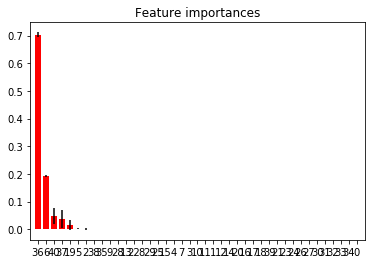

In [20]:
# Getting feature importance
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_rf.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_rf.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_rf.shape[1]), indices)
plt.xlim([-1, train_rf.shape[1]])
plt.show()

In [18]:
sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']})
preds[preds<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(preds)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("rf_4_600.csv", index=False)

In [29]:
import xgboost as xgb

In [30]:
xgb = xgb.XGBRegressor(max_depth=4, n_estimators=600, learning_rate=0.02, gamma=0, n_jobs=4)

In [24]:
val_err(xgb, train_rf, y_rf)

1.639705625708901


1.639705625708901

In [31]:
xgb.fit(train_rf, y_rf)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
preds = xgb.predict(test_rf)

In [34]:
sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']})
preds[preds<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(preds)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("xgb_4_600.csv", index=False)

In [35]:
from sklearn.svm import SVR

In [37]:
clf = SVR()

In [ ]:
val_err(clf, train_rf, y_rf)

In [ ]:
preds = xgb.predict(test_rf)

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']})
preds[preds<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(preds)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("svm_4_600.csv", index=False)